In [8]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from sklearn.metrics import (
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_fscore_support, 
    matthews_corrcoef, 
    cohen_kappa_score, 
    balanced_accuracy_score
)

from torch.nn.functional import softmax


In [9]:
class LoadDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        self.category_counts = {}

        for idx, row in self.img_labels.iterrows():
            img_path = os.path.join(img_dir, row['image'] + '.jpeg')
            if os.path.exists(img_path):
                self.data.append((img_path, row['level']))
                if row['level'] in self.category_counts:
                    self.category_counts[row['level']] += 1
                else:
                    self.category_counts[row['level']] = 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

class Square:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - w) // 2
        vp = (max_wh - h) // 2
        padding = (hp, vp, hp, vp)
        return TF.pad(image, padding, fill=0, padding_mode='constant')

transform = transforms.Compose([
    Square(),
    transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

csv_file = 'binary_labels.csv'
img_dir = './dataset'
data = LoadDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

class_counts = data.category_counts
total_count = sum(class_counts.values())
class_weights = torch.tensor([total_count / class_counts[i] for i in range(len(class_counts))], dtype=torch.float32)
print(class_counts, total_count, class_weights)

train_size = int(0.8 * len(data))
validation_size = len(data) - train_size
train_dataset, validation_dataset = random_split(data, [train_size, validation_size], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

{0: 450, 1: 1287} 1737 tensor([3.8600, 1.3497])


In [10]:
class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        attn = torch.sigmoid(self.conv(x))
        return x * attn

class CustomCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Attention(512),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg19":
        model_ft = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet121":
        model_ft = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "custom":
        model_ft = CustomCNNModel(num_classes)
        input_size = 224

    return model_ft, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
def evaluate_model(y_true, y_pred, model_outputs, num_classes):
    model_outputs = np.array(model_outputs) 
    model_outputs = softmax(torch.tensor(model_outputs), dim=1).numpy()

    cnf_matrix = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, model_outputs[:, 1])
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    top1_acc = topk_accuracy(torch.tensor(model_outputs), torch.tensor(y_true), k=1).item()
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    print(f'Confusion Matrix:\n{cnf_matrix}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    print(f'Top-1 Accuracy: {top1_acc:.2f}%')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    plot_confusion_matrix(cnf_matrix, num_classes)

def plot_confusion_matrix(cm, num_classes):
    class_names = [str(i) for i in range(num_classes)]
    cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]
    cm_percentage = np.nan_to_num(cm_percentage)

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix (%)',
           ylabel='True label',
           xlabel='Predicted label')

    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.yticks(rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_percentage[i, j]:.1%}", ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

def topk_accuracy(output, target, k=5):
    with torch.no_grad():
        maxk = min(k, output.size(1))
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / target.size(0))

def ensemble_predictions(models, val_loader, num_classes, device):
    y_true = []
    all_preds = [[] for _ in models]

    with torch.no_grad():
        for inputs, labels in val_loader:
            y_true.extend(labels.cpu().numpy())
            inputs = inputs.to(device)

            for idx, model in enumerate(models):
                model.eval()
                outputs = model(inputs)
                all_preds[idx].append(outputs.cpu().numpy())

    y_true = np.array(y_true)
    all_preds = [np.vstack(preds) for preds in all_preds]
    all_preds = np.array(all_preds)

    if all_preds.shape[1] != len(y_true):
        raise ValueError(f"Predictions shape {all_preds.shape} does not match the number of true labels {len(y_true)}")

    ensemble_preds = np.mean(all_preds, axis=0)
    y_pred = np.argmax(ensemble_preds, axis=1)

    return y_true, y_pred, ensemble_preds

In [12]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        y_true = []
        y_pred = []
        model_outputs = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                model_outputs.extend(outputs.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

    return train_losses, val_losses, y_true, y_pred, model_outputs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 2
models_list = []

Training vgg19 model...


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Felio/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


Epoch 1/100 - Train Loss: 0.7506 - Val Loss: 0.6492
Epoch 2/100 - Train Loss: 0.7260 - Val Loss: 0.6444
Epoch 3/100 - Train Loss: 0.7214 - Val Loss: 0.6639
Epoch 4/100 - Train Loss: 0.6869 - Val Loss: 0.6529
Epoch 5/100 - Train Loss: 0.7029 - Val Loss: 0.6514
Epoch 6/100 - Train Loss: 0.6893 - Val Loss: 0.6380
Epoch 7/100 - Train Loss: 0.7003 - Val Loss: 0.6558
Epoch 8/100 - Train Loss: 0.6854 - Val Loss: 0.6460
Epoch 9/100 - Train Loss: 0.6933 - Val Loss: 0.6684
Epoch 10/100 - Train Loss: 0.6787 - Val Loss: 0.6534
Epoch 11/100 - Train Loss: 0.6933 - Val Loss: 0.6526
Epoch 12/100 - Train Loss: 0.6873 - Val Loss: 0.6503
Epoch 13/100 - Train Loss: 0.6693 - Val Loss: 0.6445
Epoch 14/100 - Train Loss: 0.6787 - Val Loss: 0.6789
Epoch 15/100 - Train Loss: 0.6855 - Val Loss: 0.6570
Epoch 16/100 - Train Loss: 0.6787 - Val Loss: 0.6612
Epoch 17/100 - Train Loss: 0.6749 - Val Loss: 0.6592
Epoch 18/100 - Train Loss: 0.6833 - Val Loss: 0.6383
Epoch 19/100 - Train Loss: 0.6731 - Val Loss: 0.6501
Ep

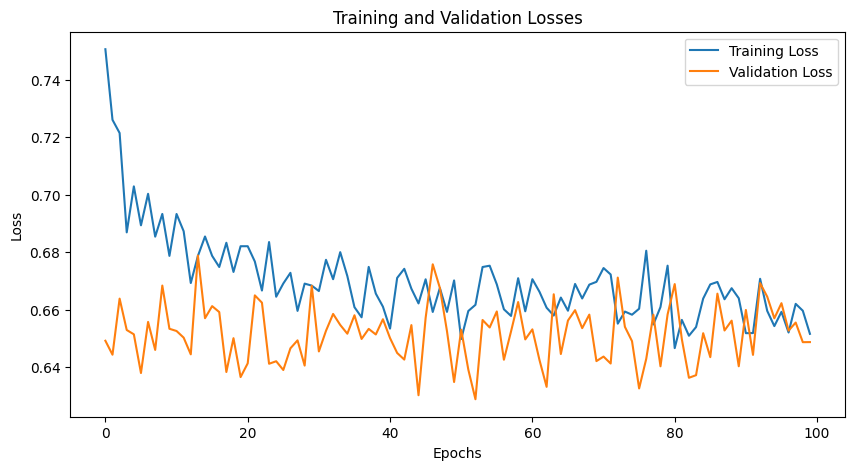

Trained model saved to vgg19_binary.pth
Confusion Matrix:
[[ 45  37]
 [ 88 178]]
ROC AUC Score: 0.6534
Precision: 0.83, Recall: 0.67, F1-Score: 0.74
Top-1 Accuracy: 64.08%
Matthews Correlation Coefficient: 0.1904
Cohen's Kappa: 0.1794
Balanced Accuracy: 0.6090


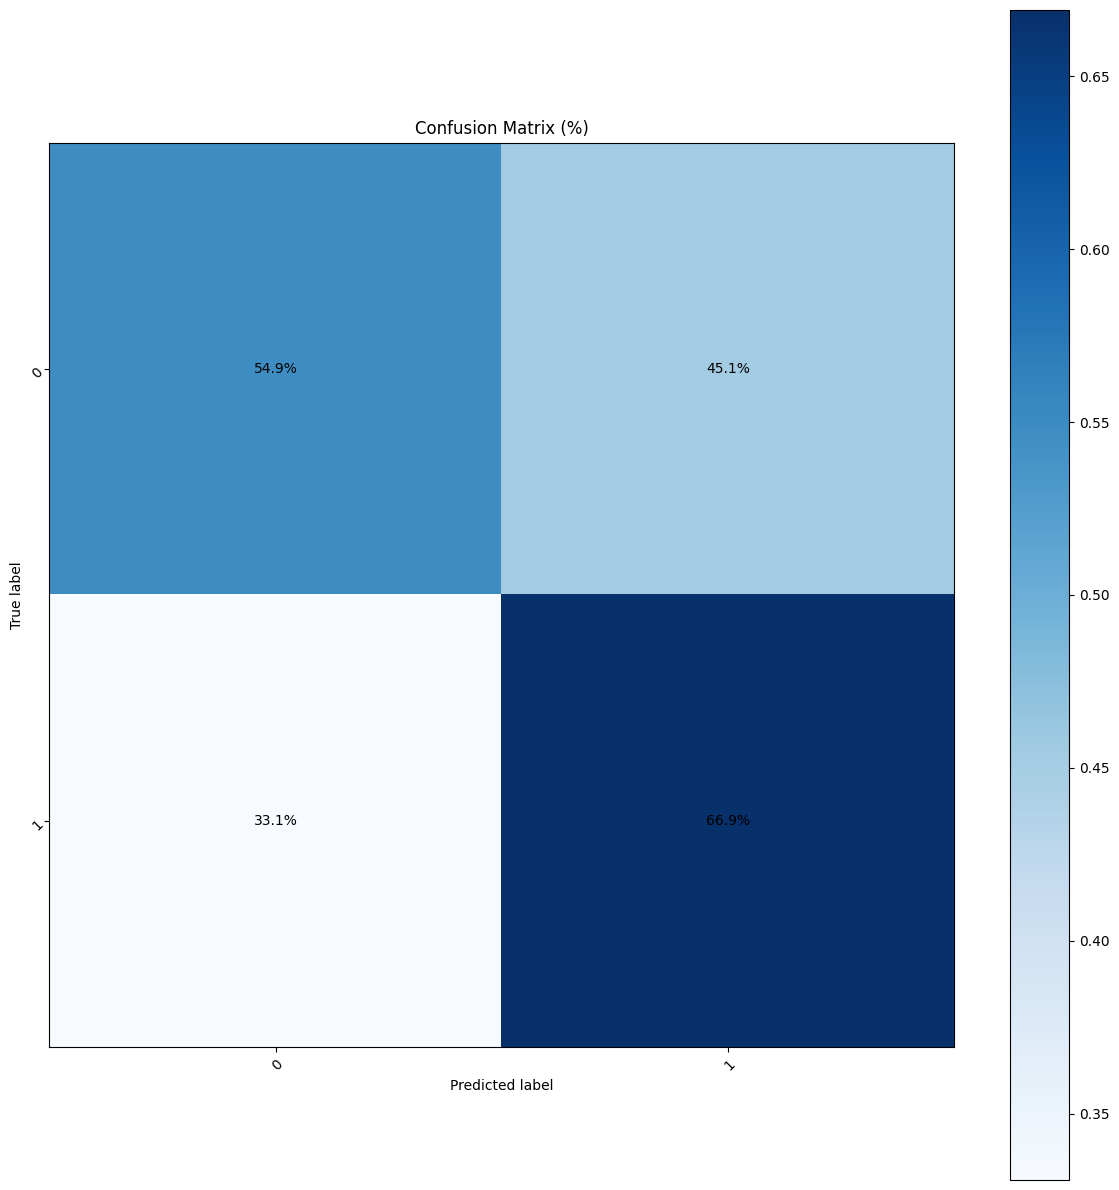

vgg19 model training and evaluation completed.



In [14]:
model_name_vgg19 = 'vgg19'
print(f"Training {model_name_vgg19} model...")

model_vgg19, input_size_vgg19 = initialize_model(model_name_vgg19, num_classes)
model_vgg19 = model_vgg19.to(device)

criterion_vgg19 = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_vgg19 = optim.Adam(model_vgg19.parameters(), lr=0.0001)

num_epochs_vgg19 = 100

train_losses_vgg19, val_losses_vgg19, y_true_vgg19, y_pred_vgg19, model_outputs_vgg19 = train_and_validate(
    model_vgg19, train_loader, validation_loader, criterion_vgg19, optimizer_vgg19, device, num_epochs=num_epochs_vgg19
)

vgg19_save_file = f"{model_name_vgg19}_binary.pth"
torch.save({
    'epoch': num_epochs_vgg19,
    'model_state_dict': model_vgg19.state_dict(),
    'optimizer_state_dict': optimizer_vgg19.state_dict(),
    'train_losses': train_losses_vgg19,
    'val_losses': val_losses_vgg19
}, vgg19_save_file)
print(f"Trained model saved to {vgg19_save_file}")

performance_vgg19 = evaluate_model(y_true_vgg19, y_pred_vgg19, model_outputs_vgg19, num_classes)
models_list.append(model_vgg19)
print(f"{model_name_vgg19} model training and evaluation completed.\n")

Training resnet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Felio/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


Epoch 1/100 - Train Loss: 0.6976 - Val Loss: 0.6742
Epoch 2/100 - Train Loss: 0.6891 - Val Loss: 0.6809
Epoch 3/100 - Train Loss: 0.6801 - Val Loss: 0.6745
Epoch 4/100 - Train Loss: 0.6722 - Val Loss: 0.6507
Epoch 5/100 - Train Loss: 0.6707 - Val Loss: 0.6516
Epoch 6/100 - Train Loss: 0.6629 - Val Loss: 0.6717
Epoch 7/100 - Train Loss: 0.6647 - Val Loss: 0.6697
Epoch 8/100 - Train Loss: 0.6656 - Val Loss: 0.6561
Epoch 9/100 - Train Loss: 0.6647 - Val Loss: 0.6545
Epoch 10/100 - Train Loss: 0.6571 - Val Loss: 0.6723
Epoch 11/100 - Train Loss: 0.6503 - Val Loss: 0.6453
Epoch 12/100 - Train Loss: 0.6561 - Val Loss: 0.6733
Epoch 13/100 - Train Loss: 0.6657 - Val Loss: 0.6449
Epoch 14/100 - Train Loss: 0.6556 - Val Loss: 0.6442
Epoch 15/100 - Train Loss: 0.6400 - Val Loss: 0.6354
Epoch 16/100 - Train Loss: 0.6480 - Val Loss: 0.6584
Epoch 17/100 - Train Loss: 0.6502 - Val Loss: 0.6538
Epoch 18/100 - Train Loss: 0.6432 - Val Loss: 0.6465
Epoch 19/100 - Train Loss: 0.6501 - Val Loss: 0.6458
Ep

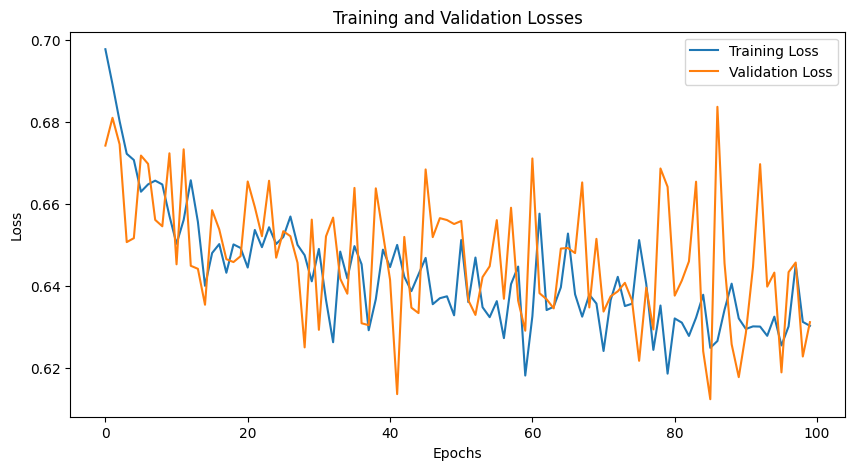

Trained model saved to resnet50_binary.pth
Confusion Matrix:
[[ 46  36]
 [ 81 185]]
ROC AUC Score: 0.6918
Precision: 0.84, Recall: 0.70, F1-Score: 0.76
Top-1 Accuracy: 66.38%
Matthews Correlation Coefficient: 0.2261
Cohen's Kappa: 0.2156
Balanced Accuracy: 0.6282


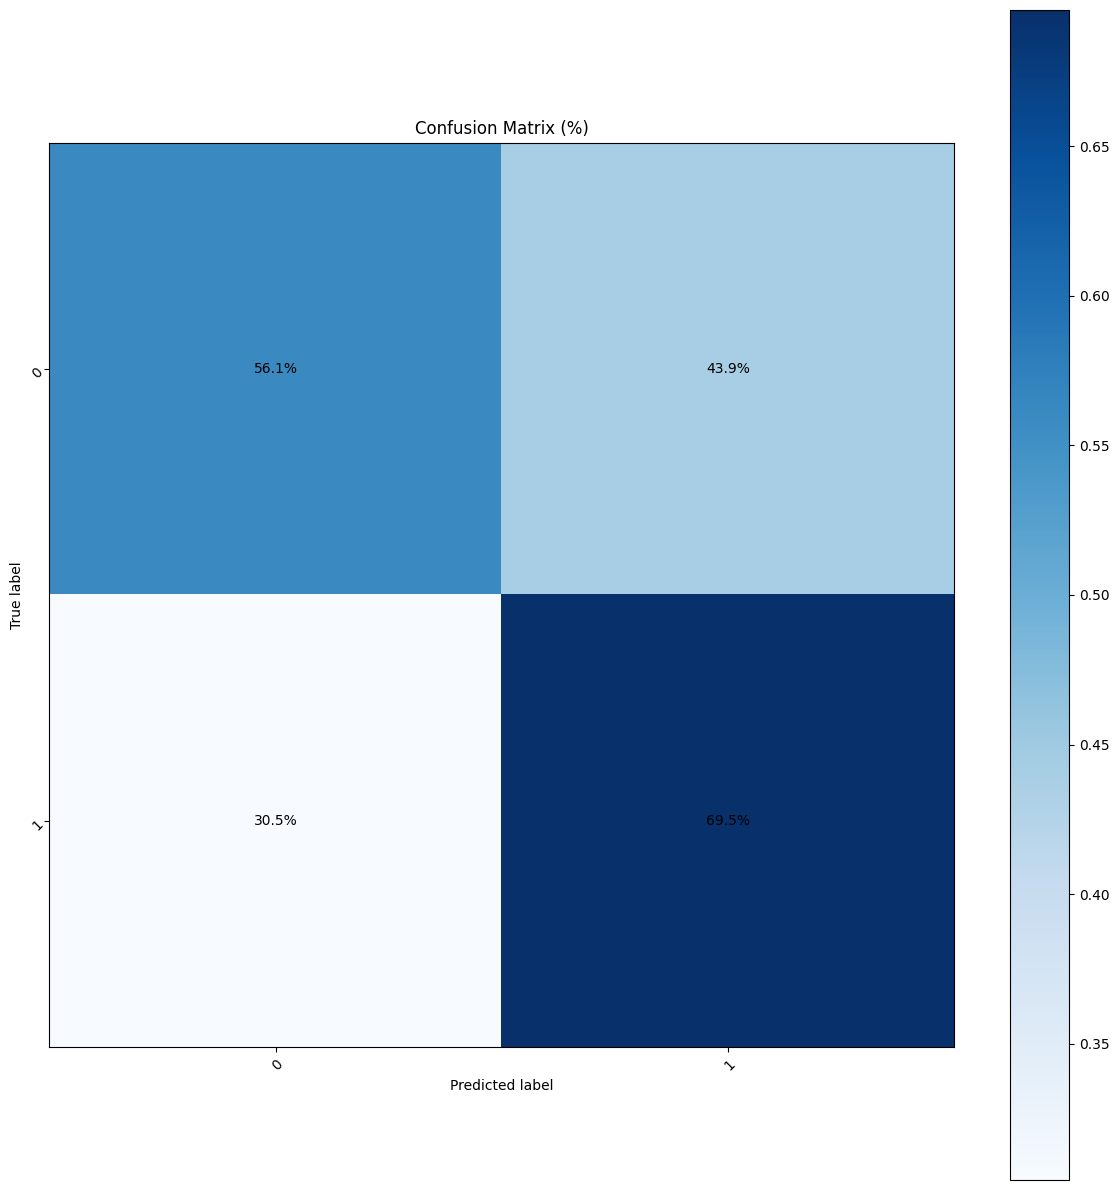

resnet50 model training and evaluation completed.



In [15]:
model_name_resnet50 = 'resnet50'
print(f"Training {model_name_resnet50} model...")

model_resnet50, input_size_resnet50 = initialize_model(model_name_resnet50, num_classes)
model_resnet50 = model_resnet50.to(device)

criterion_resnet50 = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.0001)

num_epochs_resnet50 = 100

train_losses_resnet50, val_losses_resnet50, y_true_resnet50, y_pred_resnet50, model_outputs_resnet50 = train_and_validate(
    model_resnet50, train_loader, validation_loader, criterion_resnet50, optimizer_resnet50, device, num_epochs=num_epochs_resnet50
)


resnet50_save_file = f"{model_name_resnet50}_binary.pth"
torch.save({
    'epoch': num_epochs_resnet50,
    'model_state_dict': model_resnet50.state_dict(),
    'optimizer_state_dict': optimizer_resnet50.state_dict(),
    'train_losses': train_losses_resnet50,
    'val_losses': val_losses_resnet50
}, resnet50_save_file)
print(f"Trained model saved to {resnet50_save_file}")

performance_resnet50 = evaluate_model(y_true_resnet50, y_pred_resnet50, model_outputs_resnet50, num_classes)
models_list.append(model_resnet50)
print(f"{model_name_resnet50} model training and evaluation completed.\n")

Training densenet121 model...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Felio/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100.0%


Epoch 1/100 - Train Loss: 0.7026 - Val Loss: 0.7077
Epoch 2/100 - Train Loss: 0.6962 - Val Loss: 0.6854
Epoch 3/100 - Train Loss: 0.6928 - Val Loss: 0.6648
Epoch 4/100 - Train Loss: 0.6846 - Val Loss: 0.6638
Epoch 5/100 - Train Loss: 0.6718 - Val Loss: 0.6650
Epoch 6/100 - Train Loss: 0.6793 - Val Loss: 0.6527
Epoch 7/100 - Train Loss: 0.6796 - Val Loss: 0.6632
Epoch 8/100 - Train Loss: 0.6675 - Val Loss: 0.6622
Epoch 9/100 - Train Loss: 0.6695 - Val Loss: 0.6532
Epoch 10/100 - Train Loss: 0.6684 - Val Loss: 0.6309
Epoch 11/100 - Train Loss: 0.6580 - Val Loss: 0.6579
Epoch 12/100 - Train Loss: 0.6661 - Val Loss: 0.6363
Epoch 13/100 - Train Loss: 0.6511 - Val Loss: 0.6605
Epoch 14/100 - Train Loss: 0.6592 - Val Loss: 0.6633
Epoch 15/100 - Train Loss: 0.6480 - Val Loss: 0.6507
Epoch 16/100 - Train Loss: 0.6542 - Val Loss: 0.6605
Epoch 17/100 - Train Loss: 0.6648 - Val Loss: 0.6300
Epoch 18/100 - Train Loss: 0.6460 - Val Loss: 0.6407
Epoch 19/100 - Train Loss: 0.6524 - Val Loss: 0.6403
Ep

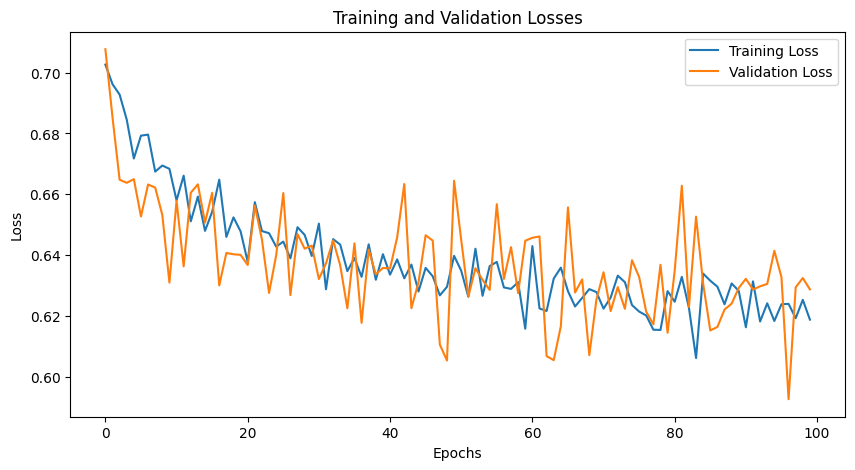

Trained model saved to densenet121_binary.pth
Confusion Matrix:
[[ 47  35]
 [ 83 183]]
ROC AUC Score: 0.6868
Precision: 0.84, Recall: 0.69, F1-Score: 0.76
Top-1 Accuracy: 66.09%
Matthews Correlation Coefficient: 0.2291
Cohen's Kappa: 0.2172
Balanced Accuracy: 0.6306


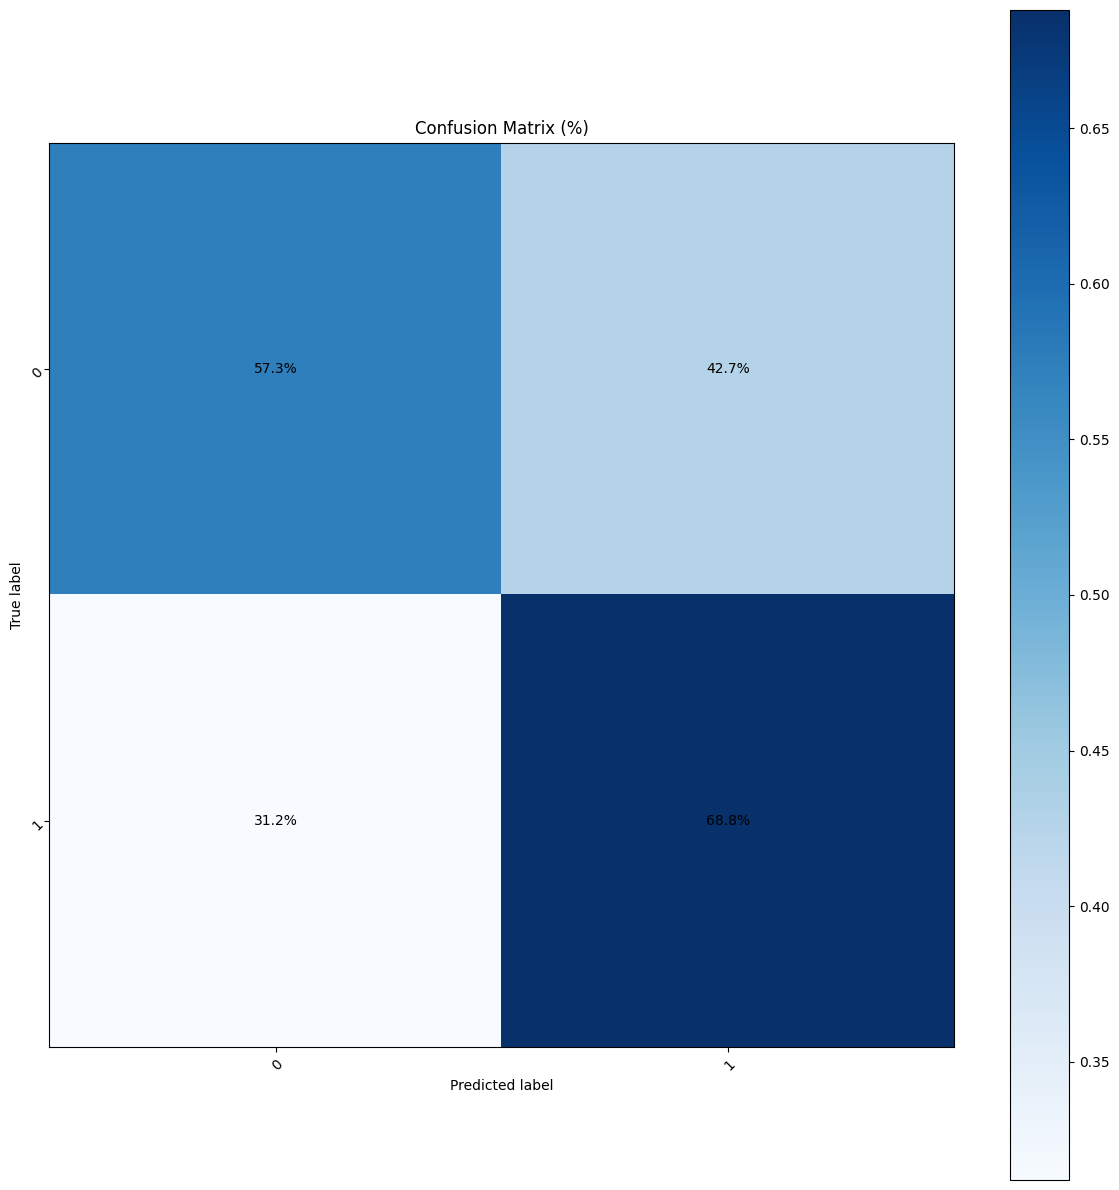

densenet121 model training and evaluation completed.



In [16]:
model_name_densenet121 = 'densenet121'
print(f"Training {model_name_densenet121} model...")


model_densenet121, input_size_densenet121 = initialize_model(model_name_densenet121, num_classes)
model_densenet121 = model_densenet121.to(device)

criterion_densenet121 = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_densenet121 = optim.Adam(model_densenet121.parameters(), lr=0.0001)

num_epochs_densenet121 = 100

train_losses_densenet121, val_losses_densenet121, y_true_densenet121, y_pred_densenet121, model_outputs_densenet121 = train_and_validate(
    model_densenet121, train_loader, validation_loader, criterion_densenet121, optimizer_densenet121, device, num_epochs=num_epochs_densenet121
)

densenet121_save_file = f"{model_name_densenet121}_binary.pth"
torch.save({
    'epoch': num_epochs_densenet121,
    'model_state_dict': model_densenet121.state_dict(),
    'optimizer_state_dict': optimizer_densenet121.state_dict(),
    'train_losses': train_losses_densenet121,
    'val_losses': val_losses_densenet121
}, densenet121_save_file)
print(f"Trained model saved to {densenet121_save_file}")

performance_densenet121 = evaluate_model(y_true_densenet121, y_pred_densenet121, model_outputs_densenet121, num_classes)
models_list.append(model_densenet121)
print(f"{model_name_densenet121} model training and evaluation completed.\n")

Training custom model...
Epoch 1/100 - Train Loss: 0.7491 - Val Loss: 0.6934
Epoch 2/100 - Train Loss: 0.7434 - Val Loss: 0.6987
Epoch 3/100 - Train Loss: 0.7341 - Val Loss: 0.6886
Epoch 4/100 - Train Loss: 0.7278 - Val Loss: 0.6887
Epoch 5/100 - Train Loss: 0.7191 - Val Loss: 0.6952
Epoch 6/100 - Train Loss: 0.7507 - Val Loss: 0.6896
Epoch 7/100 - Train Loss: 0.7300 - Val Loss: 0.6847
Epoch 8/100 - Train Loss: 0.7264 - Val Loss: 0.6930
Epoch 9/100 - Train Loss: 0.7158 - Val Loss: 0.6894
Epoch 10/100 - Train Loss: 0.7298 - Val Loss: 0.6941
Epoch 11/100 - Train Loss: 0.7202 - Val Loss: 0.6872
Epoch 12/100 - Train Loss: 0.7270 - Val Loss: 0.6886
Epoch 13/100 - Train Loss: 0.7234 - Val Loss: 0.6906
Epoch 14/100 - Train Loss: 0.7270 - Val Loss: 0.6894
Epoch 15/100 - Train Loss: 0.7115 - Val Loss: 0.6817
Epoch 16/100 - Train Loss: 0.7267 - Val Loss: 0.6891
Epoch 17/100 - Train Loss: 0.7084 - Val Loss: 0.6851
Epoch 18/100 - Train Loss: 0.7155 - Val Loss: 0.6917
Epoch 19/100 - Train Loss: 0.7

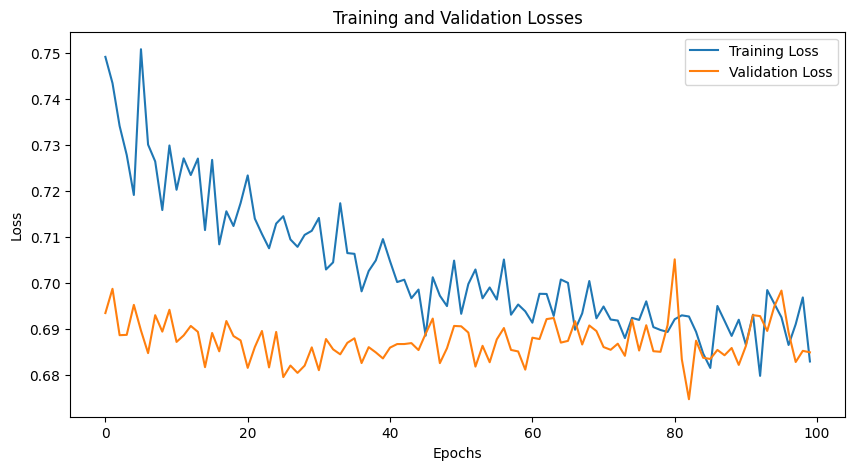

Trained model saved to custom_binary.pth
Confusion Matrix:
[[ 26  56]
 [ 66 200]]
ROC AUC Score: 0.5483
Precision: 0.78, Recall: 0.75, F1-Score: 0.77
Top-1 Accuracy: 64.94%
Matthews Correlation Coefficient: 0.0664
Cohen's Kappa: 0.0662
Balanced Accuracy: 0.5345


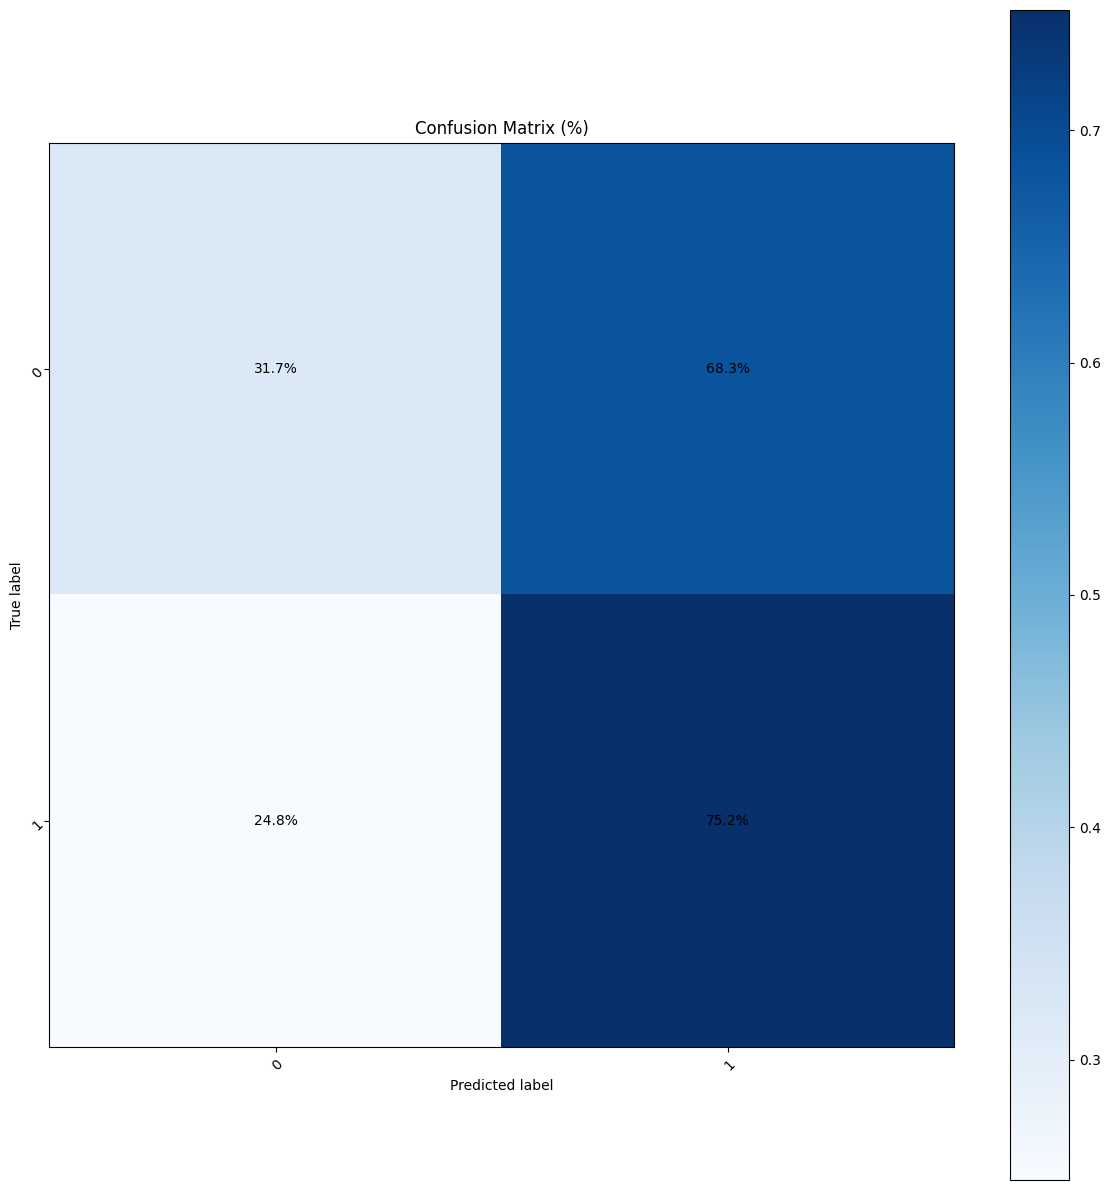

custom model training and evaluation completed.



In [17]:
model_name_custom = 'custom'
print(f"Training {model_name_custom} model...")

model_custom, input_size_custom = initialize_model(model_name_custom, num_classes)
model_custom = model_custom.to(device)

criterion_custom = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.0001)

num_epochs_custom = 100

train_losses_custom, val_losses_custom, y_true_custom, y_pred_custom, model_outputs_custom = train_and_validate(
    model_custom, train_loader, validation_loader, criterion_custom, optimizer_custom, device, num_epochs=num_epochs_custom
)

custom_save_file = f"{model_name_custom}_binary.pth"
torch.save({
    'epoch': num_epochs_custom,
    'model_state_dict': model_custom.state_dict(),
    'optimizer_state_dict': optimizer_custom.state_dict(),
    'train_losses': train_losses_custom,
    'val_losses': val_losses_custom
}, custom_save_file)
print(f"Trained model saved to {custom_save_file}")

performance_custom = evaluate_model(y_true_custom, y_pred_custom, model_outputs_custom, num_classes)
models_list_custom = models_list
models_list_custom.append(model_custom)
print(f"{model_name_custom} model training and evaluation completed.\n")

Confusion Matrix:
[[ 43  39]
 [ 87 179]]
ROC AUC Score: 0.6744
Precision: 0.82, Recall: 0.67, F1-Score: 0.74
Top-1 Accuracy: 63.79%
Matthews Correlation Coefficient: 0.1731
Cohen's Kappa: 0.1641
Balanced Accuracy: 0.5987


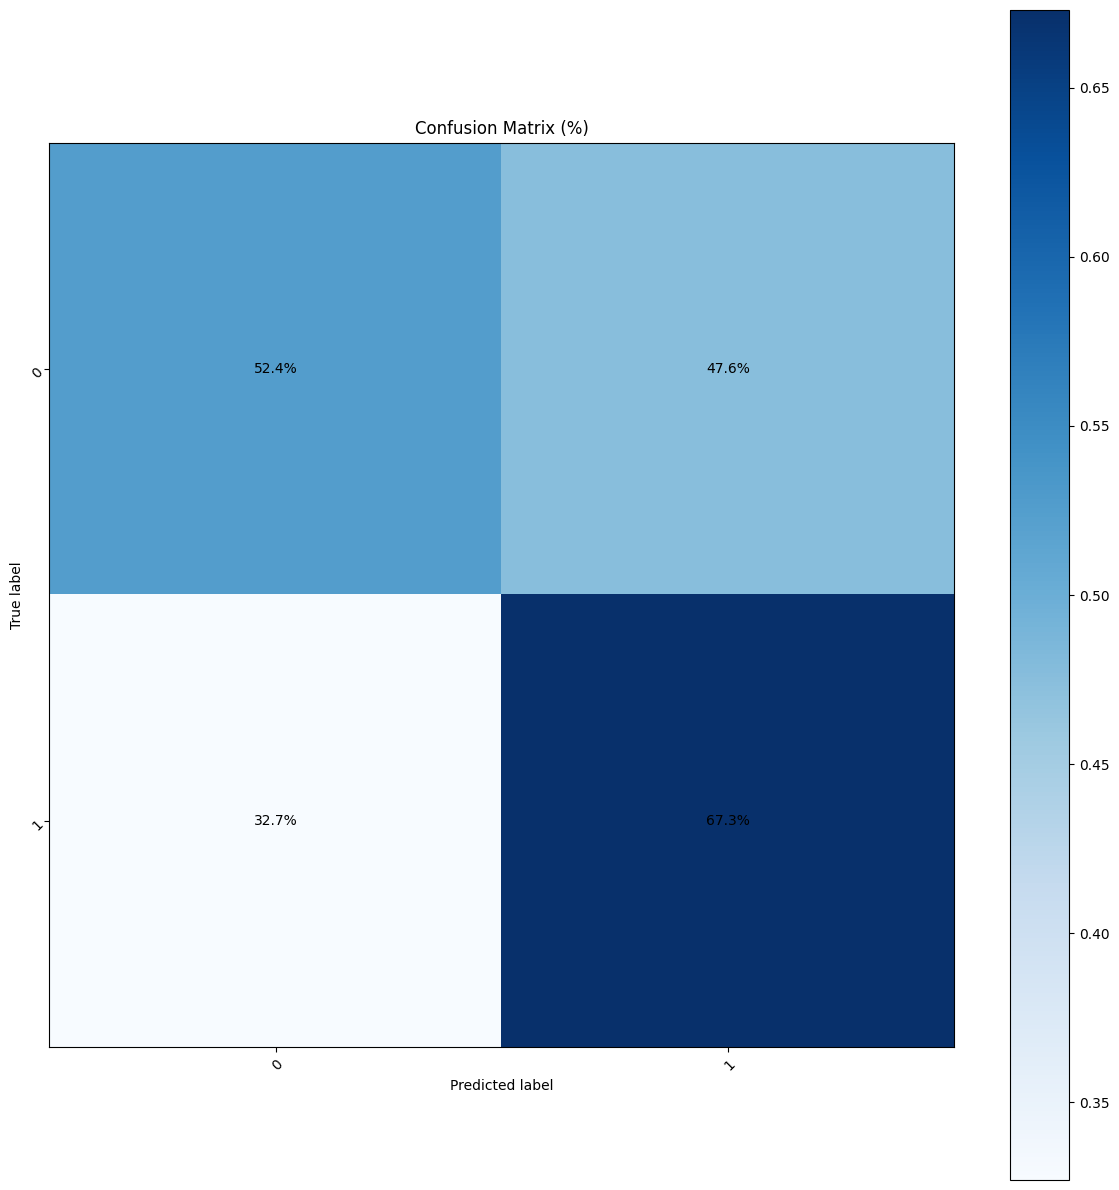

In [18]:
ensemble_y_true, ensemble_y_pred, ensemble_outputs = ensemble_predictions(models_list, validation_loader, num_classes, device)
evaluate_model(ensemble_y_true, ensemble_y_pred, ensemble_outputs, num_classes)

Confusion Matrix:
[[ 45  37]
 [ 86 180]]
ROC AUC Score: 0.7161
Precision: 0.83, Recall: 0.68, F1-Score: 0.75
Top-1 Accuracy: 64.66%
Matthews Correlation Coefficient: 0.1975
Cohen's Kappa: 0.1869
Balanced Accuracy: 0.6127


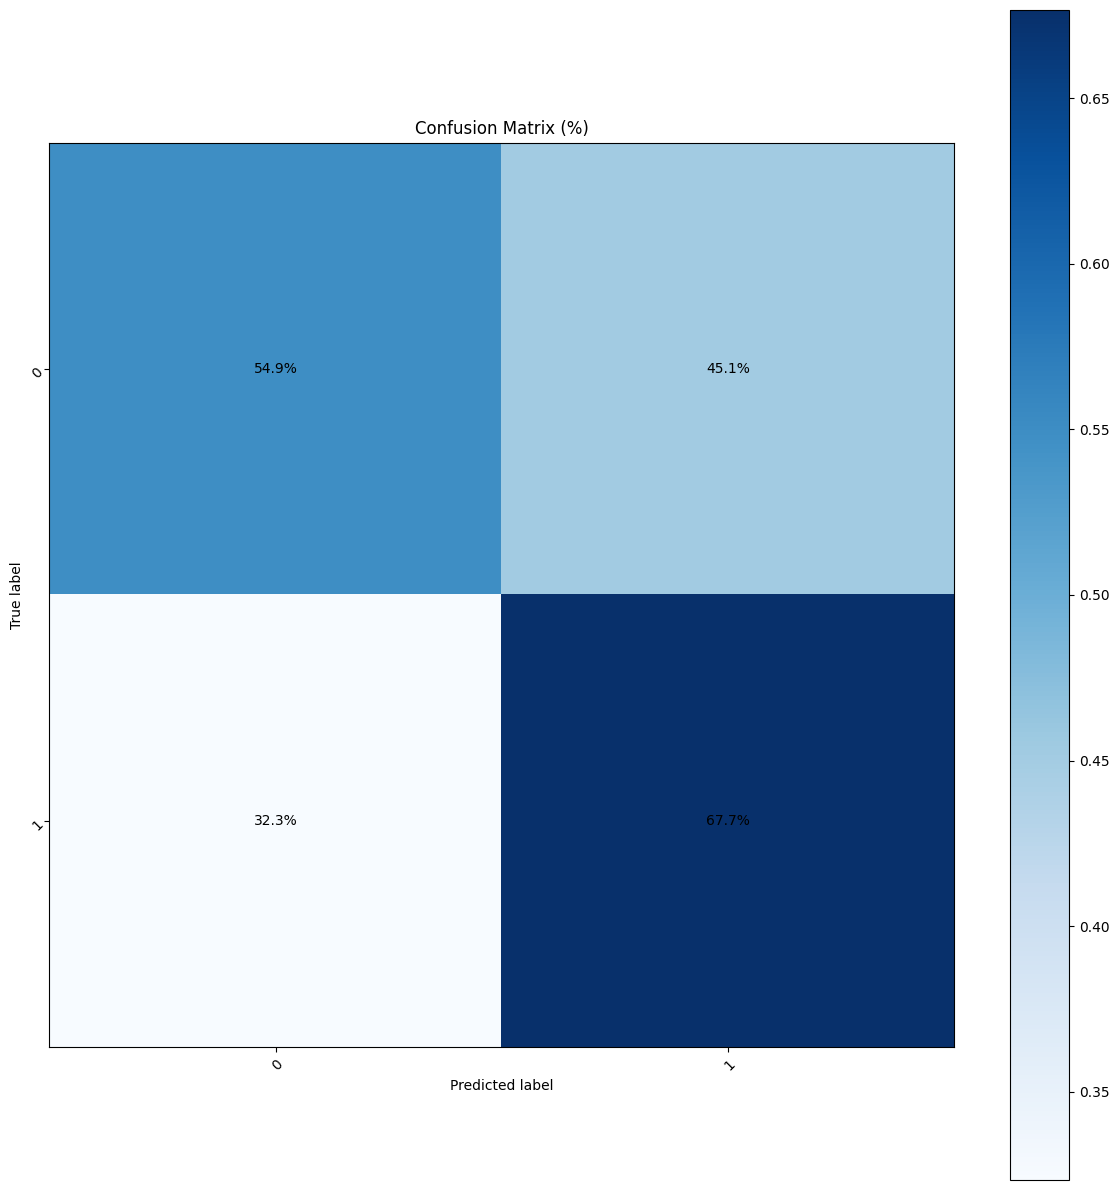

In [19]:
ensemble_y_true, ensemble_y_pred, ensemble_outputs = ensemble_predictions(models_list_custom, validation_loader, num_classes, device)
evaluate_model(ensemble_y_true, ensemble_y_pred, ensemble_outputs, num_classes)